## Flow

###### Validacia
1. Odfitrovanie participantov na zaklade kalibracie (bud zo zaciatku, alebo aj zo zaciatku a konca - pricom sa porovnava s priemerom a medzi zaciatkom a koncom)
2. Odfiltrovanie participantov na zaklade validacie oci a dat (<= validity code a percento validnych dat podla kodu)
------------
###### Preprocessing 
1. V casti preprocesingu vytiahnem len data ktore sa tykaju ulohy a kedy sa zacalo natacat (takze ide prec instrukcie a nakonci dotaznik)
2. Odfiltrujem duplicitne fixacie (teda gazepointy ktore tvoria fixacie a vyhodim take kde je niektore z bodu fixacie (x,y) Nan = Null)
3. Vypocitam si aoi pre ulohu na zaklade koordinatov (vyuzivam kniznicu shapely) 

###### Pocitanie crt
1. 

v datach sa poyerali aj mimo lebo si potrebovali zapisat odpoved na papier .. nizsia uspesnost dat

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import string
import itertools

from IPython.display import clear_output
from shapely.geometry import Point, Polygon

from scipy import stats

In [2]:
# Machine learning
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples, silhouette_score 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import preprocessing # predspracovanie dat - scale
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

In [3]:
# Custom modules
from data_validation import data_validation_filter as dvf
from data_processing import aoi as ac
from data_processing import data_preprocessing as dp

# RQA
from algorithms.RQA import DynamicalSystemsModule as RecurrenceFunctions
from algorithms.RQA import SpatioTemporalEyeTrackingModule as ReoccurrenceFunctions

In [4]:
import pyclustering.cluster.dbscan as cluster
import pyclustering.cluster.kmedoids as kmedoid
from configparser import ConfigParser
import codecs

#### Globals

In [5]:
TASKS = {
    "1":["IE_1.tsv", "1.txt"],
    "2":["IE_2.tsv", "2.txt"],
    "3":["IE_3.tsv", "3.txt"],
    "4":["IE_4.tsv", "4.txt"],
    "5":["IE_5.tsv", "5.txt"],
    "6":["IE_6.tsv", "6.txt"],
    "7":["IE_7.tsv", "7.txt"],
    "8":["IE_8.tsv", "8.txt"]
}
TASK_DATA_NAMES = ["IE_1", "IE_2", "IE_3", "IE_4", "IE_5", "IE_6", "IE_7", "IE_1"]
AOI_DATA_NAMES = ["1.txt","2.txt","3.txt","4.txt","5.txt","6.txt","7.txt","8.txt"]
STUDIO_EVENTS = ['InstructionStart', 'InstructionEnd', 'ScreenRecStarted', 'URLStart', 
                 'URLEnd', 'ScreenRecStopped', 'QuestionStarted','QuestionEnded']

#column_names = ["Name","AOI Hits","Fixations count","Fixations duration","Average fix duration","Scanpath"]

In [6]:
class Participant:
    
    def __init__(self, name):
        self.data = {}
        self.data["Name"] = name
        self.data["Scanpath"] = ""
        self.data["ScanpathShort"] = ""
        self.data["NumberOfAoisHits"] = 0
        self.data["NumberOfAoisHitsShort"] = 0
        self.data["NumberOfFixations"] = 0
        self.data["FixationsDuration"] = 0
        self.data["AverageFixationDuration"] = 0
        
        #RQA
        # Reoccurrence
        self.data["reoccurrence"] = 0
        self.data["reoccurrenceRate"] = 0
        self.data["reoccurrenceDeterminism"] = 0
        self.data["reoccurrenceLaminarity"] = 0
        self.data["reoccurrenceCORM"] = 0
        # Recurrence
        self.data["recurrence"] = 0
        self.data["recurrenceRate"] = 0
        self.data["recurrenceMeanX"] = 0
        self.data["recurrenceMeanY"] = 0
        self.data["recurrenceStandardDeviationX"] = 0
        self.data["recurrenceStandardDeviationY"] = 0
        
        # New 
        #self.data["AverageSaccadeDuration"] = 0
        #self.data["NumberOfSaccades"] = 0
        #self.data["SaccadeSpeed"] = 0
        #
        #self.data["OutlierScore"] = 0
        
        # For RQA
        self.fixations = []
        self.outlierScore = 0
        self.completeTask = False
        self.passCalibration = False
        self.passValidation = False
        self.hasEnoughData = False

        
    def set_data(self, key, value):
        self.data[key] = value

In [36]:
def clusters_to_labels(X, clusters, noise = []):
    labels = [0] * len(X)
    for nois in noise:
        labels[nois] = -1
        
    i = 0  
    for one_cluster in clusters:
        for one in one_cluster:
            labels[one] = i
        i += 1
    
    return np.array(labels, dtype="int64")


def pair_labels_with_participants_dict(labels, df_names):
    participants_labels = {}
    i = 0
    for i in range(0,len(df_names)):
        participants_labels[df_names[i]] = round(labels[i], 3)
    return participants_labels

def pair_scores_with_participants(scores, df_names):
    participants_scores = []
    #i = 0
    for i in range(0,len(df_names)):
        participants_scores.append([df_names[i], round(scores[i], 3)])
    return participants_scores

def pair_labels_with_participants(labels, df_names):
    participants_labels = []
    i = 0
    for i in range(0,len(df_names)):
        participants_labels.append([df_names[i], labels[i]])
    return participants_labels


def get_participants_with_label(labels, label, testers_names, all_participants):
    indexes = np.where(labels == label)[0]
    return list(map(lambda i: all_participants[testers_names[i]], indexes))


def transform_data(data):
    data_array = []
    for d in data:
        data_array.append(d.data)
        
    return data_array


def outliers_nd_sd(X_scores, paired_scores):
# https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html
# http://colingorrie.github.io/outlier-detection.html
    final_list = []
    final_list_temp = []
    outliers = []
    mean = np.mean(X_scores, axis=0)
    sd = np.std(X_scores, axis=0)

    #final_list = [x for x in paired_labels_orig if (x[1] > mean - 2 * sd)]
    for x in paired_scores:
        if(x[1] > mean - 2 * sd):
            final_list_temp.append(x)
        else:
            outliers.append(x)
    #final_list = [x for x in final_list if (x[1] < mean + 2 * sd)]
    for x in final_list_temp:
        if(x[1] < mean + 2 * sd):
            final_list.append(x)
        else:
            outliers.append(x)
            
    return outliers

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

In [8]:
def calculate_user_features(dataset, _participant):
    print("Working on " + _participant.data["Name"])
    # Vytiahnem data od konkretneho usera
    d = dataset[dataset['ParticipantName'] == _participant.data["Name"]]
    # Vyfiltrujem data na konkretny task 
    # (neuvazujem Instrukcie alebo Questionare na konci - len ked sa zacalo a skoncilo nahravanie)
    d = dp.filter_users_data_to_task(d)
    # Vyfiltrujem take fixacie ktore su NaN, teda neboli zaznamenane a nedalo by sa s nimi pracovat
    d = dp.filter_users_fixations(d)
    
    #_participant = Participant(tester)
    #_participant = tester
    
    if(len(d) == 0):
        _participant.hasEnoughData = False
        return _participant 
    
     # init
    allFixations = []
    scanpath = ""
    scanpathShort = ""
    scanpathLength = 0
    scanpathShortLength = 0
    numberOfAoisHits = 0
    numberOfAoisHitsShort = 0
    numberOfFixations = 0
    fixationsDuration = 0
    averageFixationDuration = 0
   

    #_participant = Participant(tester)


    # Prechadzam jednotlive riadky
    for index, row in d.iterrows():
       
        fixationPoint = Point(row['FixationPointX (MCSpx)'], row['FixationPointY (MCSpx)'])
        allFixations.append(fixationPoint)
        fixationsDuration += row['GazeEventDuration']
        numberOfFixations += 1

        for aoi in aois:
            if aois[aoi].contains(fixationPoint):
                scanpath += aoi
                numberOfAoisHits += 1
                break
    
    scanpathShort = ''.join(ch for ch, _ in itertools.groupby(scanpath))
    numberOfAoisHitsShort = len(scanpathShort)
    averageFixationDuration = ((fixationsDuration/numberOfFixations) / 1000) if numberOfFixations > 0 else 0
    
    _participant.set_data("Scanpath", scanpath)
    _participant.set_data("ScanpathShort", scanpathShort)
    _participant.set_data("NumberOfFixations", numberOfFixations)
    _participant.set_data("NumberOfAoisHits", numberOfAoisHits)
    _participant.set_data("NumberOfAoisHitsShort", numberOfAoisHitsShort)
    _participant.set_data("FixationsDuration", fixationsDuration / 1000) # in seconds
    _participant.set_data("AverageFixationDuration", averageFixationDuration)
    #_participant.scanpath = scanpath
    #_participant.scanpath_short = ''.join(ch for ch, _ in itertools.groupby(scanpath))
    #_participant.allFixationsDuration = duration
    
    _participant.fixations = allFixations
    calculate_RQA_features(_participant)
    
    #all_participants[tester] = _participant
    _participant.hasEnoughData = True
    return _participant
    

### RQA

In [9]:
def calculate_RQA_features(participant):
    clusteringDistanceThreshold = 70
    timeDelayValue = 1
    numTimeDelaySamples = 3
    phaseSpaceClusteringThreshold = 0.5

    results = {}
    fixations = []
    for fixation in participant.fixations:
        fixations.append([int(fixation.x), int(fixation.y)])
        #print(fixation)
        # reoccurrences
    #clusteringDistanceThreshold = int(parser.get('RQA', 'clusteringDistanceThreshold'))
    matrix = ReoccurrenceFunctions.CreateReoccurrenceMatrix(fixations, clusteringDistanceThreshold=clusteringDistanceThreshold)
   
    #Added 
    #results["Name"] = parti.name
    results["reoccurrence"] = ReoccurrenceFunctions.getReoccurrence(matrix)
    results["reoccurrenceRate"] = ReoccurrenceFunctions.getReoccurrenceRate(matrix)
    results["reoccurrenceDeterminism"] = ReoccurrenceFunctions.getDeterminism(matrix)
    results["reoccurrenceLaminarity"] = ReoccurrenceFunctions.getLaminarity(matrix)
    results["reoccurrenceCORM"] = ReoccurrenceFunctions.getCORM(matrix)
    

    #reccurrences
    #timeDelayValue = int(parser.get('RQA', 'timeDelayValue'))
    #numTimeDelaySamples = int(parser.get('RQA', 'numTimeDelaySamples'))
    #phaseSpaceClusteringThreshold = float(parser.get('RQA', 'phaseSpaceClusteringThreshold'))
    fixationsXYPhaseSpaceData = RecurrenceFunctions.TimeDelayEmbedding(timeSeriesObservations=fixations,
                                                                       delayStep=timeDelayValue,
                                                                       delaySamples=numTimeDelaySamples)
    recurrenceMatrixData = RecurrenceFunctions.CreateRecurrenceMatrix(phaseSpaceData=fixationsXYPhaseSpaceData,
                                                                      clusteringDistanceThreshold= 	phaseSpaceClusteringThreshold );

    results["recurrence"] = RecurrenceFunctions.getRecurrence(recurrenceMatrixData, numTimeDelaySamples);
    results["recurrenceRate"] = RecurrenceFunctions.getRecurrenceRate(recurrenceMatrixData, numTimeDelaySamples);
    (results["recurrenceMeanX"], results["recurrenceMeanY"]) = RecurrenceFunctions.getRecurrenceMean(recurrenceMatrixData, numTimeDelaySamples);
    (results["recurrenceStandardDeviationX"],results["recurrenceStandardDeviationY"]) = RecurrenceFunctions.getRecurrenceStandardDeviation(recurrenceMatrixData,
                                                                                             numTimeDelaySamples);
    #reoccurrence[parti.name] = results
   
    for resultKey in results:
        participant.set_data(resultKey, results[resultKey])

### Load dataset and aois

In [10]:
task_number = "7"
chosen_task = TASKS[task_number]
dataset = pd.read_csv("data/data_by_tasks/" + chosen_task[0], low_memory=False, sep="\t")
aois = ac.load_and_process_aoi(chosen_task[1])

#### Load config file

In [11]:
parser = ConfigParser()
with codecs.open('config.ini', 'r', encoding='utf-8') as f:
    parser.read_file(f)

# Participanti, ktori nesplnili ulohy (prevzal som to od Mokreho ako to mal on)
dont_complete_task = parser.get('delete', task_number).split("\n")

### Get all participansts, their names and create instances

In [12]:
all_participants = {}
all_testers_names = dataset['ParticipantName'].unique()
for tester in all_testers_names:
    all_participants[tester] = Participant(tester)

#### Filter participants based on calibration values and Filter users who don't pass calibration

In [13]:
# Filter based on the calibration values at the beginning of the experiment
df_after_calibration = dvf.calibration_filter(dataset, "begin", 0.85, 0.85)
testers_names_calib = df_after_calibration['ParticipantName'].unique()

all_participants_after_calibration = {}
dont_pass_calibration = list(set(all_testers_names) - set(testers_names_calib))

for tester in all_participants:
    if tester not in dont_pass_calibration:
        all_participants[tester].passCalibration = True
        all_participants_after_calibration[tester] = all_participants[tester]

print(str(len(all_participants)) + " -> " + str(len(all_participants_after_calibration)))

58 -> 57


#### Filter participants based on eye validation and Filter users who don't pass validation

In [14]:
# Filter dataset based on validation
dataset_filtered = dvf.eyes_validity_filter(dataset, 2, 25)
testers_names_validation = dataset_filtered['ParticipantName'].unique()

all_participants_after_validation = {}
dont_pass_validation = list(set(all_testers_names) - set(testers_names_validation))

for tester in all_participants:
    if tester not in dont_pass_validation:
        all_participants[tester].passValidation = True
        all_participants_after_validation[tester] = all_participants[tester]

print(str(len(all_participants)) + " -> " + str(len(all_participants_after_validation)))

58 -> 49


#### Filter users who don't complete task

In [15]:
all_participants_who_complete = {}
for tester in all_participants:
    if tester not in dont_complete_task:
        all_participants[tester].completeTask = True
        all_participants_who_complete[tester] = all_participants[tester]
        
print(str(len(all_participants)) + " -> " + str(len(all_participants_who_complete)))

58 -> 51


#### Get users who pass

In [16]:
all_participants_after_complete_check = {}
for tester in all_participants:
    if(all_participants[tester].completeTask == True & all_participants[tester].passValidation == True & all_participants[tester].passCalibration == True):
        all_participants_after_complete_check[tester] = all_participants[tester]
        
print(str(len(all_participants)) + " -> " + str(len(all_participants_after_complete_check)))

58 -> 44


#### Calculate user's features (if participant has enough data)

In [17]:
all_participants_features = {}
dont_have_enough_data = []

for tester in all_participants_after_complete_check:
    all_participants[tester] = calculate_user_features(dataset, all_participants_after_calibration[tester])
    if(all_participants[tester].hasEnoughData == True):
        all_participants_features[tester] = all_participants[tester]
    else:
        dont_have_enough_data.append(tester)
        
len(all_participants_features)

Working on Tester46
Working on tester68
Working on tester49
Working on tester52
Working on tester26
Working on tester38
Working on tester48
Working on tester36
Working on tester56
Working on tester39
Working on tester54
Working on tester42
Working on tester10
Working on tester08
Working on tester22
Working on tester31
Working on tester69
Working on tester44
Working on tester53
Working on tester70
Working on tester34
Working on tester28
Working on tester43
Working on tester65
Working on tester17
Working on tester11
Working on tester40
Working on tester 35
Working on tester30
Working on tester33
Working on tester51
Working on tester 29
Working on tester47
Working on tester24
Working on tester71
Working on tester09
Working on tester63
Working on tester37
Working on tester07
Working on tester20
Working on tester61
Working on tester60
Working on tester58
Working on tester64


44

In [18]:
overall_dropouts = list(set(all_testers_names) - set(all_participants_features.keys()))
df_cleaned = dataset
for tester in overall_dropouts:
    df_cleaned = df_cleaned[df_cleaned['ParticipantName'] != tester]

In [118]:
print("Participants who didn't pass through calibration = " + str(len(dont_pass_calibration)) + " -> " + str(dont_pass_calibration))
print("Participants who didn't complete task = " + str(len(dont_complete_task)) + " -> " + str(dont_complete_task))
print("Participants who didn't pass through validation = " + str(len(dont_pass_validation)) + " -> " + str(dont_pass_validation))
print("Participants who didn't have enough data = " + str(len(dont_have_enough_data)) + " -> " + str(dont_have_enough_data))
print("-----------")
print("All Participants who passed = " + str(len(overall_dropouts)) + " -> " + str(overall_dropouts))

Participants who didn't pass through calibration = 1 -> ['tester18']
Participants who didn't complete task = 7 -> ['tester27', 'tester41', 'tester57', 'tester59', 'tester66', 'tester32', 'tester50']
Participants who didn't pass through validation = 9 -> ['tester55', 'tester50', 'tester18', 'tester21', 'tester14', 'tester25', 'tester12', 'tester41', 'tester13']
Participants who didn't have enough data = 0 -> []
-----------
All Participants who passed = 14 -> ['tester55', 'tester50', 'tester66', 'tester59', 'tester18', 'tester21', 'tester14', 'tester25', 'tester32', 'tester12', 'tester13', 'tester41', 'tester27', 'tester57']


### Prepare data and put data to array

In [91]:
colors = ["red","cyan", "green","blue","yellow","magenta","black","white"]
all_data = []

for tester in all_participants_features:
    df_tester = all_participants[tester]
    all_data.append(df_tester.data)

columns_to_drop = ['Name','Scanpath','ScanpathShort','FixationsDuration']
df_all_data = pd.DataFrame(all_data)
#df_all_data = df_cluster_1
df_names = df_all_data['Name'].copy()
df_ = df_all_data.drop(columns=columns_to_drop)
df_final = df_.values.tolist()
X = preprocessing.scale(df_final)

## Finding outliers in data

Skusal som dva pristupy:

1) Nad celym datasetom pustim LOF a najdem outlierov


2) Najdem 2 zhluky participantov (k-means alebo k-medoids), kvalitu zhlukov overim podla indexu (pri troch zhlukoch tam uz algoritmus nevedel najst velke rozdiely) a nad jednotlivymi zhlukmi pustim LOF a najdem outlierov


## 1. Pristup

### KMeans

Silhouette Coefficient: 0.620


<IPython.core.display.Javascript object>


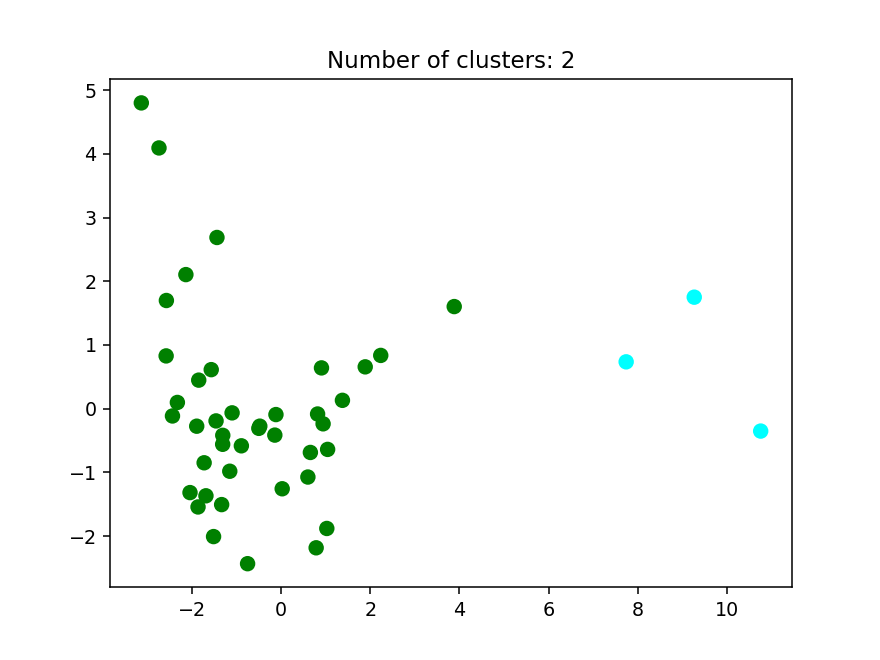

Text(0.5,1,'Number of clusters: 2')

In [85]:
kmeans = KMeans(n_clusters=2,init="k-means++", n_init=15, random_state=0).fit(X)

labels = kmeans.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

plt.figure()
# Vytvorenie a nafitovanie PCA modelu
pca = PCA(n_components=2).fit(X)
plot = pca.transform(X)
plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in labels], s=50)  

# Zobrazenie PCA 2D modelu
title = "Number of clusters: %d" % n_clusters_
plt.title(title)

#### Get data from each cluster 

In [88]:
gpw_0_names = [n.data["Name"] for n in get_participants_with_label(labels, 0, df_names, all_participants)]
gpw_1_names = [n.data["Name"] for n in get_participants_with_label(labels, 1, df_names, all_participants)]
df_cluster_0 = df_all_data.loc[df_all_data['Name'].isin(gpw_0_names)]
df_cluster_1 = df_all_data.loc[df_all_data['Name'].isin(gpw_1_names)]

### Prepare data from one cluster to LOF

In [61]:
df_all_data_grp = df_cluster_1
#df_all_data = df_cluster_1
df_names_lof = df_all_data_grp['Name'].copy()
df_lof = df_all_data_grp.drop(columns=columns_to_drop)
df_final_lof = df_.values.tolist()
X_lof = preprocessing.scale(df_final_lof)

## LOF - Local outlier factor

http://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.correlation.html#scipy.spatial.distance.correlation
https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

Pouzivam korelaciu ako metriku porovnavania, skusal som viac roznych parametrov a metrik  (odkazy hore v linkoch).
V pripade velkeho susedstva - 20+ , tie korelacie voebc nevyniknu a porovnavaju sa participanti s velkou vzorkou
V pripade velmi maleho susedstva - pod 5 napr. uz tie korelacie nemusia mat taku vypovednu hodnotu kedze sa to porovnava 
s malou vzorkou.

Preto som volil susedstvo od 5 do 10 kedy nachadzalo priblizne 1-3 outlierov v datach pricom ich skore sa az tak vyrazne neodlisovalo


Metriky ako Minkowski, chebyshev a pod. vzdy oznacili za outlierov ako tych, ktory boli vzdialenostne najdalej od ostatnej skupiny vzoriek. V tomto pripade to boli taki co plnili ulohu dlhsie alebo mali viac fixacii (v pripade, ze berieme participantov ako expert-zaciatocnik tak by som oznacil tychto ako zaciatocnikov). Takyto participanti teda niesu outliermi, iba patria do ineho zhluku. Chcel nieco co by hladalo podobnosti medzi paticipantmi v zhlukoch v ramci susedstva a preto som skusil pouzit korelaciu.
Teda ak v ramci jeho blizkeho susedstva mal nizke skore, predpokladam ze v ramci susedstva bol odlisny a mohli by sme ho oznacit za outliera. Tym vsak neoznacujeme, ze data ma chybne, ale skor ze nejakym sposobom jeho spravanie vytrca nad ostatnymi

<IPython.core.display.Javascript object>


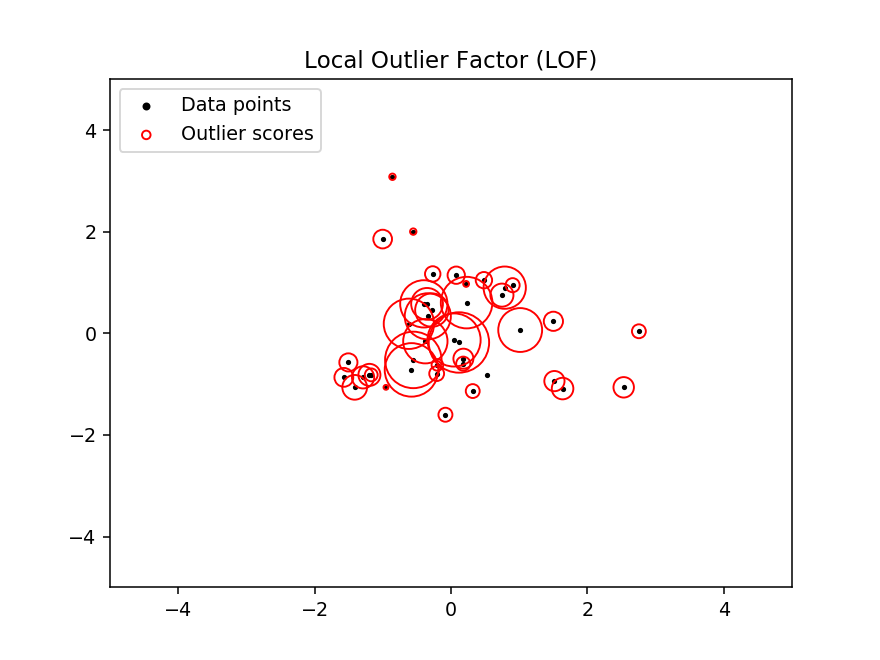

In [65]:
clf = LocalOutlierFactor(n_neighbors=7, contamination=0.05, metric="correlation")
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X_lof)
X_scores = clf.negative_outlier_factor_
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X_lof[:, 0], X_lof[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X_lof[:, 0], X_lof[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

Poparujem participantov a ich skore

In [66]:
#pl = pair_labels_with_participants(radius, df_names)
#ss = sorted(pl.items(), key=lambda x: x[1])

paired_scores_orig = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores_sorted = sorted(paired_scores, key=lambda x: x[1])
pddf = pd.DataFrame(paired_scores_sorted)
pddf

,0,1
0,tester69,-1.652
1,tester24,-1.563
2,tester10,-1.498
3,tester49,-1.490
4,tester38,-1.458
5,tester07,-1.434
6,tester 35,-1.375
7,tester44,-1.354
8,tester43,-1.322
9,tester53,-1.314


### Find Outliers Using Normal Distribution and S.D

Kedze neviem urcit treshold pre outlier skore, ktore bolo vystupom z algoitmu LOF tak tym neviem oznacit, kto uz na zaklade skore je a kto nie je outlier. Preto pouzijem normalnu distribuciu spolu so standardnou odchylkou a na zaklade hodnot skorej najde v datach take skore, ktore mozme povazovat za anomalne. (Skusal som aj z-skore)

In [73]:
#outliers = outliers_z_score(X_scores)
outliers = outliers_nd_sd(X_scores, paired_scores_orig)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Finded outliers in data -> ['tester69', 'tester24']


### Compare data without outliers  to outliers data

#### Data with outliers

In [79]:
df_cluster_1_outliers = df_cluster_1.loc[df_cluster_1['Name'].isin(outliers)]
df_cluster_1_outliers.describe()

,AverageFixationDuration,FixationsDuration,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.000000,2.000000
mean,0.188620,11.618000,61.000000,9.000000,61.000000,425.000000,29.022804,37.911458,0.270068,98.205670,131.865249,85.500000,-17.123317,0.0,0.652273,4.506801
std,0.022666,3.249863,9.899495,1.414214,9.899495,77.781746,1.576418,2.986053,0.045216,1.186524,1.455559,38.890873,13.232569,0.0,0.296696,0.641616
min,0.172593,9.320000,54.000000,8.000000,54.000000,370.000000,27.908108,35.800000,0.238095,97.366671,130.836014,58.000000,-26.480156,0.0,0.442478,4.053110
25%,0.180606,10.469000,57.500000,8.500000,57.500000,397.500000,28.465456,36.855729,0.254082,97.786170,131.350632,71.750000,-21.801736,0.0,0.547376,4.279955
50%,0.188620,11.618000,61.000000,9.000000,61.000000,425.000000,29.022804,37.911458,0.270068,98.205670,131.865249,85.500000,-17.123317,0.0,0.652273,4.506801
75%,0.196633,12.767000,64.500000,9.500000,64.500000,452.500000,29.580152,38.967187,0.286054,98.625169,132.379867,99.250000,-12.444897,0.0,0.757171,4.733646
max,0.204647,13.916000,68.000000,10.000000,68.000000,480.000000,30.137500,40.022917,0.302041,99.044668,132.894485,113.000000,-7.766477,0.0,0.862069,4.960492


In [90]:
df_cluster_1_without_outliers = df_cluster_1.loc[~df_cluster_1['Name'].isin(outliers)]
df_cluster_1_without_outliers.describe()

,AverageFixationDuration,FixationsDuration,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.199610,15.433154,76.102564,12.025641,77.717949,1314.410256,35.204536,51.704801,0.369801,170.371774,251.758207,184.666667,-11.045731,3.327121,3.900281,6.049670
std,0.049587,8.415062,42.206756,8.752405,42.684244,1394.736831,16.932134,26.894168,0.117913,127.687159,195.022597,151.958674,20.378780,5.044128,5.228062,3.565662
min,0.123775,3.903000,10.000000,2.000000,20.000000,16.000000,11.625000,14.000000,0.133333,8.859196,12.119200,2.000000,-46.648551,0.000000,0.200803,1.052632
25%,0.170397,8.346000,42.000000,6.000000,42.000000,303.000000,20.751780,28.164397,0.305231,61.593321,93.870497,61.500000,-23.706970,0.601709,1.053098,3.785661
50%,0.189510,14.086000,70.000000,9.000000,70.000000,670.000000,31.203666,44.050916,0.345888,116.291062,181.957807,157.000000,-12.998591,1.587302,2.083333,5.416667
75%,0.223163,23.363000,103.000000,14.500000,104.500000,2178.500000,48.092317,73.817041,0.428863,274.724459,386.584721,256.000000,-2.931978,3.374097,3.990774,7.097249
max,0.331117,32.216000,201.000000,43.000000,204.000000,6148.000000,82.213077,119.914444,0.674510,560.262533,767.215627,586.000000,55.263158,21.739130,25.000000,20.027341


## 2. pristup

## LOF - nad celym datasetom

### 2.1 Metric - correlation

<IPython.core.display.Javascript object>


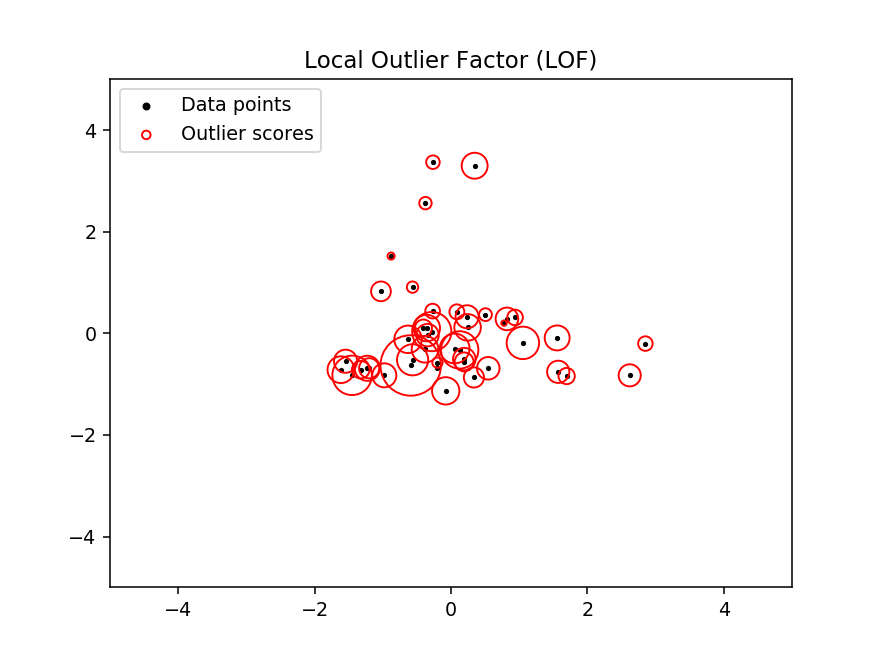

In [110]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05, metric="correlation")
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

#### Pair participants with their score

In [105]:
paired_scores_orig = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores_sorted = sorted(paired_scores, key=lambda x: x[1])
pddf = pd.DataFrame(paired_scores_sorted)
pddf

,0,1
0,tester39,-3.200
1,tester52,-2.732
2,tester28,-2.357
3,tester30,-1.936
4,tester11,-1.890
5,tester56,-1.679
6,tester61,-1.632
7,tester36,-1.559
8,tester37,-1.458
9,tester58,-1.384


In [96]:
#outliers = outliers_z_score(X_scores)
outliers = outliers_nd_sd(X_scores, paired_scores_orig)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Outliers in data -> ['tester10']


### Compare data 

In [103]:
df_outliers = df_all_data.loc[df_all_data['Name'].isin(outliers)]
if(len(df_outliers) > 1):
    s = df_outliers.describe()
else:
    s = df_outliers
    
s

,AverageFixationDuration,FixationsDuration,Name,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,Scanpath,ScanpathShort,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
12,0.1713,8.565,tester10,46,14,50,CCDEEDBBABDCCCGFFCCCCEGGGGGGGGGGGGGGGGGGGGGGGG,CDEDBABDCGFCEG,332.0,24.725904,34.629518,0.320773,84.516982,118.80654,51,-21.488595,0.0,0.980392,4.163265


In [98]:
df_without_outliers = df_all_data.loc[~df_all_data['Name'].isin(outliers)]
df_without_outliers.describe()

,AverageFixationDuration,FixationsDuration,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,0.199381,18.654442,92.627907,13.581395,94.325581,2612.255814,40.858763,63.038212,0.369156,236.742464,379.974857,254.604651,-10.761487,3.076886,3.593268,5.765995
std,0.047341,14.549469,73.359202,11.303671,74.282191,5210.767497,26.586232,50.120301,0.116664,282.469647,524.739940,324.789832,19.653793,4.864854,5.067160,3.529992
min,0.123775,3.903000,10.000000,2.000000,20.000000,16.000000,11.625000,14.000000,0.133333,8.859196,12.119200,2.000000,-46.648551,0.000000,0.200803,1.052632
25%,0.172567,9.492500,42.000000,6.500000,42.500000,343.000000,21.614068,31.080135,0.302498,72.802782,105.583406,68.500000,-23.706970,0.413418,0.878796,3.412571
50%,0.189510,14.407000,77.000000,9.000000,77.000000,860.000000,34.297852,48.343604,0.345888,156.455231,203.178232,160.000000,-9.914530,1.546392,1.804124,5.342625
75%,0.218531,24.740500,113.000000,16.500000,113.500000,2280.500000,51.782371,76.085370,0.428863,282.873443,423.179760,286.500000,-2.931978,2.678571,3.540998,7.013374
max,0.331117,70.686000,334.000000,53.000000,340.000000,26914.000000,124.494501,232.039385,0.674510,1385.501126,2554.219778,1847.000000,55.263158,21.739130,25.000000,20.027341


### 2.2 Metric - minkowski

<IPython.core.display.Javascript object>


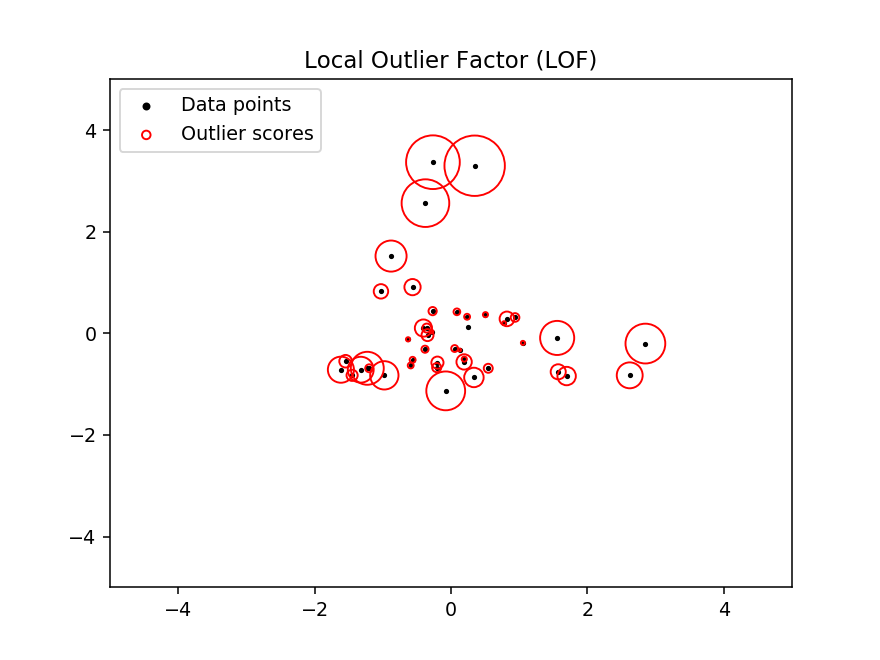

In [111]:
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05, metric="minkowski")
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(X)
X_scores = clf.negative_outlier_factor_
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

#### Pair participants with their score

In [112]:
paired_scores_orig = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores = pair_scores_with_participants(X_scores, np.array(df_names))
paired_scores_sorted = sorted(paired_scores, key=lambda x: x[1])
pddf = pd.DataFrame(paired_scores_sorted)
pddf

,0,1
0,tester39,-3.200
1,tester52,-2.732
2,tester28,-2.357
3,tester30,-1.936
4,tester11,-1.890
5,tester56,-1.679
6,tester61,-1.632
7,tester36,-1.559
8,tester37,-1.458
9,tester58,-1.384


In [116]:
#outliers = outliers_z_score(X_scores)
outliers = outliers_nd_sd(X_scores, paired_scores_orig)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Outliers in data -> ['tester52', 'tester39', 'tester28']


### Compare

In [114]:
df_outliers = df_all_data.loc[df_all_data['Name'].isin(outliers)]
if(len(df_outliers) > 1):
    s = df_outliers.describe()
else:
    s = df_outliers
    
s

,AverageFixationDuration,FixationsDuration,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.194211,61.859000,313.000000,37.000000,317.666667,20182.333333,116.876732,217.654169,0.410703,1141.177465,2125.141611,1208.666667,-6.400795,0.849459,0.691802,2.383444
std,0.018056,9.684313,32.140317,18.330303,29.670412,5927.807717,9.665440,20.351410,0.096883,212.803296,378.567990,554.222278,10.978039,0.429875,0.364319,0.934905
min,0.181338,51.500000,276.000000,17.000000,284.000000,15743.000000,106.004002,194.368735,0.317875,996.328541,1838.265344,850.000000,-16.408447,0.433135,0.351922,1.612008
25%,0.183891,57.445500,302.500000,29.000000,306.500000,16816.500000,113.067848,210.461562,0.360461,1019.015635,1910.602527,889.500000,-12.271777,0.628332,0.499490,1.863586
50%,0.186444,63.391000,329.000000,41.000000,329.000000,17890.000000,120.131694,226.554388,0.403047,1041.702728,1982.939710,929.000000,-8.135107,0.823529,0.647059,2.115164
75%,0.200648,67.038500,331.500000,47.000000,334.500000,22402.000000,122.313097,229.296886,0.457117,1213.601927,2268.579744,1388.000000,-1.396969,1.057620,0.861743,2.769162
max,0.214851,70.686000,334.000000,53.000000,340.000000,26914.000000,124.494501,232.039385,0.511187,1385.501126,2554.219778,1847.000000,5.341170,1.291712,1.076426,3.423160


In [115]:
df_without_outliers = df_all_data.loc[~df_all_data['Name'].isin(outliers)]
df_without_outliers.describe()

,AverageFixationDuration,FixationsDuration,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,recurrence,recurrenceMeanX,recurrenceMeanY,recurrenceRate,recurrenceStandardDeviationX,recurrenceStandardDeviationY,reoccurrence,reoccurrenceCORM,reoccurrenceDeterminism,reoccurrenceLaminarity,reoccurrenceRate
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.199074,15.247049,75.365854,11.878049,76.902439,1271.024390,34.902988,51.031955,0.364936,166.851476,245.909770,179.829268,-11.342198,3.164822,3.741841,5.974408
std,0.048524,8.260080,41.299368,8.559191,41.792227,1373.244579,16.560251,26.389451,0.117185,125.445368,191.874522,149.807861,20.016599,4.969664,5.144895,3.493101
min,0.123775,3.903000,10.000000,2.000000,20.000000,16.000000,11.625000,14.000000,0.133333,8.859196,12.119200,2.000000,-46.648551,0.000000,0.200803,1.052632
25%,0.171300,8.565000,42.000000,6.000000,42.000000,332.000000,21.040146,30.361314,0.302041,65.404101,97.404177,58.000000,-23.729730,0.284091,0.980392,3.964194
50%,0.189510,13.916000,69.000000,9.000000,69.000000,583.000000,30.137500,40.022917,0.344004,114.098259,149.355383,148.000000,-12.998591,1.546392,2.040816,5.396825
75%,0.222212,23.261000,100.000000,14.000000,101.000000,2114.000000,46.452239,73.274828,0.421272,272.638894,385.922043,254.000000,-3.057303,2.857143,3.633721,7.056452
max,0.331117,32.216000,201.000000,43.000000,204.000000,6148.000000,82.213077,119.914444,0.674510,560.262533,767.215627,586.000000,55.263158,21.739130,25.000000,20.027341


In [ ]:
# Removing outliers from data to another clustering? -
all_data = []
for tester in all_participants_features:
    if tester not in outliers:
        df_tester = all_participants[tester]
        all_data.append(df_tester.data)

columns_to_drop = ['Name','Scanpath','ScanpathShort','FixationsDuration']
df_temp2 = pd.DataFrame(all_data)
df_names = df_temp2['Name'].copy()
df_ = df_temp2.drop(columns=columns_to_drop)
df_final = df_.values.tolist()
X = preprocessing.scale(df_final)

### TODO overenie ?

In [ ]:
mySequences = {}
i = 0
for tester in all_participants:
    if(all_participants[tester].data["ScanpathShort"] != ''):
        mySequences[i] = all_participants[tester].data["ScanpathShort"]
        i += 1

In [225]:
# First-Pass
highestFidelity = False
ToleranceThreshold = 1.0
mySequences_num = {}
keys = mySequences.keys()
print(mySequences[keys[0]])
for y in range (0 , len (keys)):
    #print(keys[y] mySequences[keys[y]])
    if (len(mySequences[keys[y]])!=0):
        mySequences_num[keys[y]] = getNumberedSequence(mySequences[keys[y]])
    else:
        mySequences_num[keys[y]] = []

if highestFidelity is not True:
    ToleranceThreshold = toleranceLevel * len(keys)		
    myImportanceThreshold = calculateImportanceThreshold(mySequences_num, ToleranceThreshold)
    myImportantAoIs = updateAoIsFlag(getNumberDurationOfAoIs(mySequences_num), myImportanceThreshold)
    myNewSequences = removeInsignificantAoIs(mySequences_num, myImportantAoIs)

    #Second-Pass
    myNewAoIList = getExistingAoIList(myNewSequences)
    myNewAoIList = calculateTotalNumberDurationofFixationsandNSV(myNewAoIList, 
                                                                 calculateNumberDurationOfFixationsAndNSV(myNewSequences))
    myFinalList = getValueableAoIs(myNewAoIList, ToleranceThreshold)
    myFinalList.sort( key = lambda x: (x[4], x[3], x[2]))
    myFinalList.reverse()

    commonSequence = []
    for y in range (0, len(myFinalList)):
        commonSequence.append(myFinalList[y][0])
        
    trendingPath = getAbstractedSequence(commonSequence)
    print("Trending Path:" + trendingPath)
else:
    tolerantPaths = []
    for toleranceLevel in [float(j) / 100 for j in range(0, 101)]:
        ToleranceThreshold = toleranceLevel * len(keys)		
        myImportanceThreshold = calculateImportanceThreshold(mySequences_num, ToleranceThreshold)
        myImportantAoIs = updateAoIsFlag(getNumberDurationOfAoIs(mySequences_num), myImportanceThreshold)
        myNewSequences = removeInsignificantAoIs(mySequences_num, myImportantAoIs)

        #Second-Pass
        myNewAoIList = getExistingAoIList(myNewSequences)
        myNewAoIList = calculateTotalNumberDurationofFixationsandNSV(myNewAoIList, calculateNumberDurationOfFixationsAndNSV(myNewSequences))
        myFinalList = getValueableAoIs(myNewAoIList, ToleranceThreshold)
        myFinalList.sort( key = lambda x: (x[4], x[3], x[2]))
        myFinalList.reverse()

        commonSequence = []
        for y in range (0, len(myFinalList)):
            commonSequence.append(myFinalList[y][0])
        
        trendingPath = getAbstractedSequence(commonSequence)
    
        myNewNormalSequences_Temp = {}
        myNewNormalSequences_Temp = getAbstractedSequences(mySequences)

        keys = myNewNormalSequences_Temp.keys()
        for y in range (0 , len (keys)):
            tempSequence = []
            for z in range (0, len(myNewNormalSequences_Temp[keys[y]])):
                tempSequence.append(myNewNormalSequences_Temp[keys[y]][z][0])
            myNewNormalSequences_Temp[keys[y]] = getAbstractedSequence(tempSequence)
    
        tolerantPaths.append([trendingPath,calculateAverageSimilarity(myNewNormalSequences_Temp, trendingPath),toleranceLevel])
    tolerantPaths.sort( key = lambda x: x[1])
    tolerantPaths.reverse()
    print("Trending Path: " + tolerantPaths[0][0])
    print("Tolerance Level: " + tolerantPaths[0][2])

TypeError: 'dict_keys' object does not support indexing

## Testing other unsupervised approaches

### DBSCAN

Silhouette Coefficient: 0.268


<IPython.core.display.Javascript object>


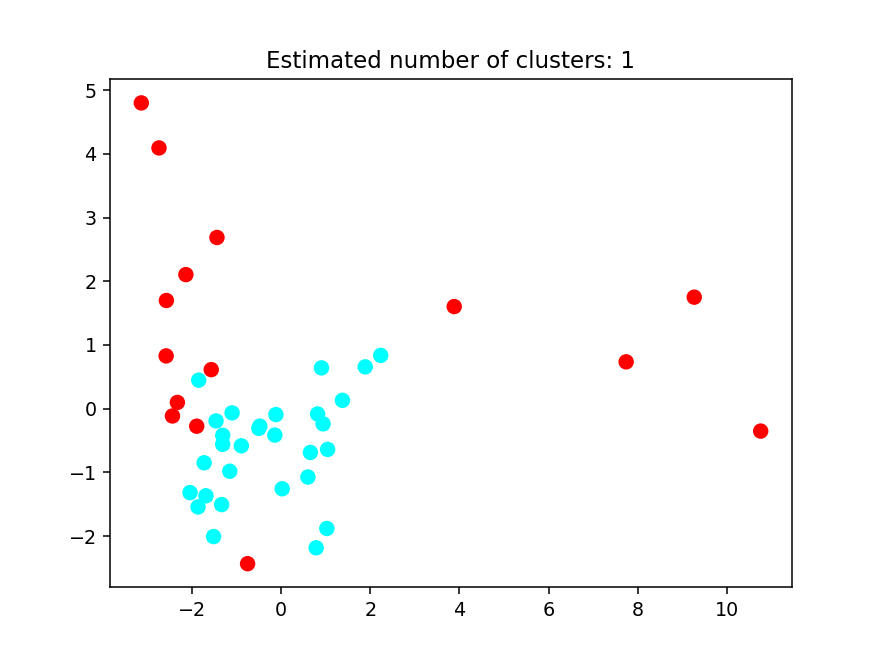

Text(0.5,1,'Estimated number of clusters: 1')

In [103]:
#db = DBSCAN(algorithm="auto",eps=2.0, min_samples = 2, metric="euclidean").fit(X)
db = DBSCAN(algorithm="auto",eps=2.0, min_samples = 2, metric="euclidean").fit(X)

#print(db)

labels = db.labels_

#print(set(labels))
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
#print(colors)


#Silhoutteov index (-1,1) - ako je dobre nauceny model
#Silhouette_avg = silhouette_score(X, labels,metric='euclidean')
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))
#print("Pre n_clusters =", n_clusters_,
 #     "Priemerne silhouette_score je :", silhouette_avg, )


plt.figure()
# Vytvorenie a nafitovanie PCA modelu
pca = PCA(n_components=2).fit(X)
plot = pca.transform(X)
plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in labels], s=50)  

# Zobrazenie PCA 2D modelu
title = "Estimated number of clusters: %d" % n_clusters_
plt.title(title)

### DBSCAN - pyclustering

Silhouette Coefficient: 0.501


<IPython.core.display.Javascript object>


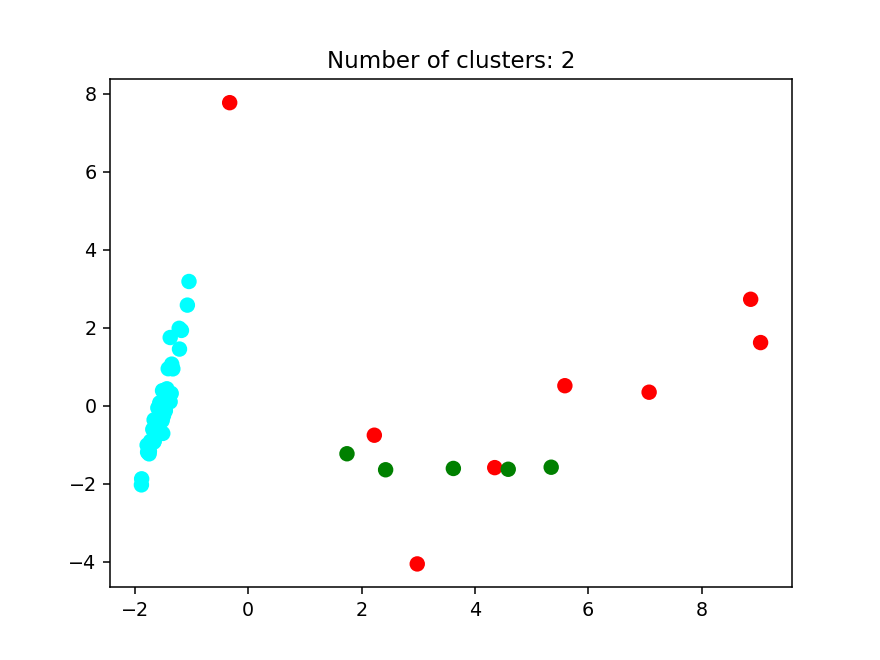

Text(0.5,1,'Number of clusters: 2')

In [30]:
dbscan_instance = cluster.dbscan(X, 3.0, 2, True);

# cluster analysis
dbscan_instance.process();

# obtain results of clustering
clusters = dbscan_instance.get_clusters();
noise = dbscan_instance.get_noise();

new_labels = clusters_to_labels(X, clusters, noise)

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, new_labels))

plt.figure()
# Vytvorenie a nafitovanie PCA modelu
pca = PCA(n_components=2).fit(X)
plot = pca.transform(X)
plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in new_labels], s=50)  

# Zobrazenie PCA 2D modelu
title = "Number of clusters: %d" % len(clusters)
plt.title(title)

### K-MEDOIDS - pyclustering

Silhouette Coefficient: 0.573


<IPython.core.display.Javascript object>


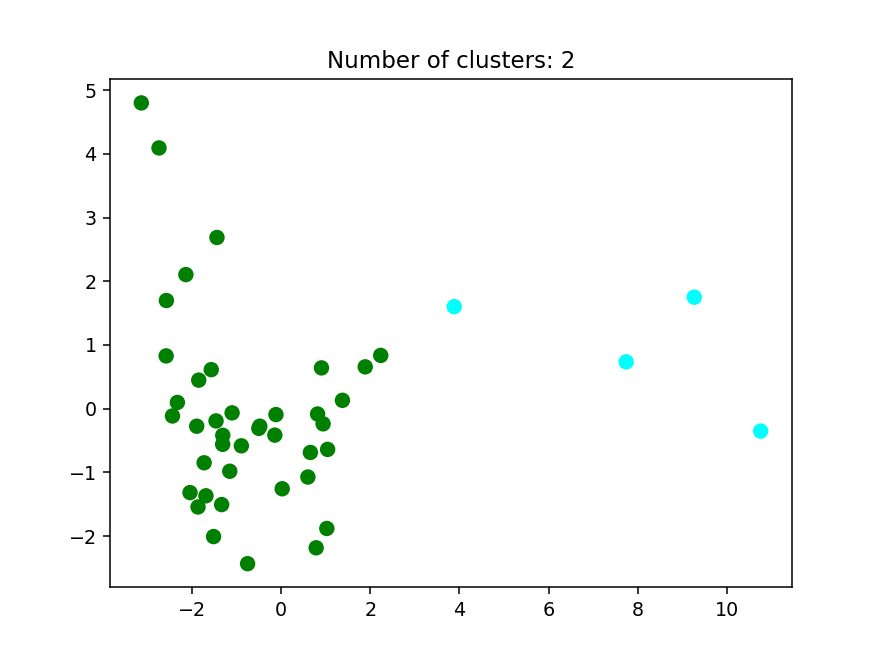

Text(0.5,1,'Number of clusters: 2')

In [104]:
initial_medoids = [1,20]
        
# create instance of K-Medoids algorithm
kmedoids_instance = kmedoid.kmedoids(X, initial_medoids)

# run cluster analysis and obtain results
kmedoids_instance.process();
clusters = kmedoids_instance.get_clusters()

new_labels = clusters_to_labels(X, clusters)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, new_labels))

plt.figure()
# Vytvorenie a nafitovanie PCA modelu
pca = PCA(n_components=2).fit(X)
plot = pca.transform(X)
plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in new_labels], s=50)  

# Zobrazenie PCA 2D modelu
title = "Number of clusters: %d" % len(clusters)
plt.title(title)

In [109]:
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
# http://scikit-learn.org/stable/auto_examples/applications/plot_outlier_detection_housing.html

OVERENIE - spolocna sekvencia, podobna podobnost, schopnost najst zhluky v datach
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
postupne nabalovat tie kroky a vediet ich porovnat, ci to pomohlo/nepomohlo, ake to malo postupne vysledky na ulohu

v com to je lepsie a kedy to zlepsenie nastalo
treba rozoznat participantov
ziskat lepsi prehlad o datach

vyhnut sa nafitovania cross-validaciou , bootstraping
nahodna podmnozina

treba premysliet ci setup funguje len na mojom alebo vseobecne?

vyhodnocovat metodu po castiach, aky maju vplyv na vysledok ulohy

https://datascience.stackexchange.com/questions/20286/overfitting-in-an-unsupervised-technique